In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics.cluster import v_measure_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [2]:
# dataset contains user locations until 2012 (Finland)
df = pd.read_csv('MopsiLocationsUntil2012-Finland.txt', sep='\t', header = None)
df

,0,1
0,625983,297439
1,626146,297440
2,626144,297456
3,626004,297394
4,626018,297437
...,...,...
13462,626042,297444
13463,625977,297443
13464,626050,297404
13465,625995,297426


In [3]:
col_labels = ['Latitude', 'Longitude']
df.columns = col_labels
df

,Latitude,Longitude
0,625983,297439
1,626146,297440
2,626144,297456
3,626004,297394
4,626018,297437
...,...,...
13462,626042,297444
13463,625977,297443
13464,626050,297404
13465,625995,297426


In [4]:
df.columns

Index(['Latitude', 'Longitude'], dtype='object')

In [5]:
transform_df = df.astype(str)

In [6]:
for col in transform_df: # "col" is the label (i.e., column name in df)
    transform_df[col] = (transform_df[col].str[:2] + '.' + transform_df[col].str[2:]).astype(float)
transform_df

,Latitude,Longitude
0,62.5983,29.7439
1,62.6146,29.7440
2,62.6144,29.7456
3,62.6004,29.7394
4,62.6018,29.7437
...,...,...
13462,62.6042,29.7444
13463,62.5977,29.7443
13464,62.6050,29.7404
13465,62.5995,29.7426


In [7]:
transform_df.shape

(13467, 2)

In [9]:
# this dataset is so pretty! no missing values are found
transform_df.isna().sum()

Latitude     0
Longitude    0
dtype: int64

In [11]:
print('Minimum Coordinates: ', transform_df['Latitude'].min(), transform_df['Longitude'].min())
print('Maximum Coordinates: ', transform_df['Latitude'].max(), transform_df['Longitude'].max())

Minimum Coordinates:  59.9247 21.2016
Maximum Coordinates:  69.7835 31.4328


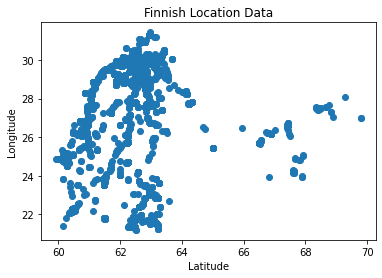

In [15]:
# let's look at the data on a scatteplot
plt.scatter(transform_df['Latitude'], transform_df['Longitude'])
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Finnish Location Data')
plt.show()

Since this dataset did not contain any observations with missing values or coordinates, very minimal preprocessing has been performed with the exception of converting the two columns of integer type to float, matching the format of geographic coordinates. We can perhaps use clustering to group these *n* coordinates into clusters based on location similarity. 

In [16]:
scaler = StandardScaler()
scaled_coords = scaler.fit_transform(transform_df)
print(len(scaled_coords))

13467


Let's run K-Means on the Finnish Location Data to get a general sense of the distribution of points across each cluster relative to the centroid. 

In [26]:
# finding optimal number of clusters
sum_of_squared_distances = pd.DataFrame(data = [], index = range(2,15), columns = ['inertia'])

for k in range(2, 15):
    trial_kmeans = KMeans(n_clusters = k)
    cutoff = 99
    trial_kmeans.fit(scaled_coords)
    sum_of_squared_distances.loc[k] = trial_kmeans.inertia_

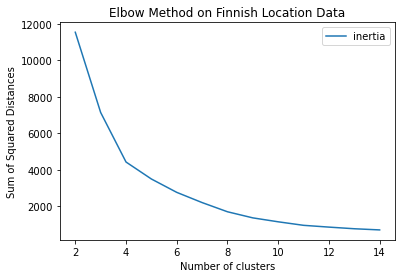

In [27]:
ax = plt.gca()

sum_of_squared_distances.plot(kind = 'line', y = 'inertia', ax = ax)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method on Finnish Location Data')
plt.show()

From the line graph above, we observe an elbow begin to form around k = 8. Let's visualize the outcome when k = 8.

In [35]:
kmeans = KMeans(n_clusters = 8).fit(scaled_coords)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

Text(0.5, 1.0, 'K-Means on Finnish Location Data (k=8)')

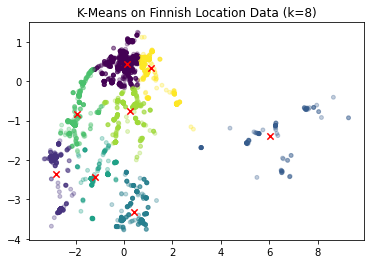

In [36]:
plt.scatter(scaled_coords[:,0], scaled_coords[:,1], c = labels, s = 15, alpha = 0.3)
plt.scatter(centroids[:,0], centroids[:,1], c = 'red', marker = 'x', s = 40, alpha = 1)
plt.title('K-Means on Finnish Location Data (k=8)')

In [37]:
kmeans_sil_score = metrics.silhouette_score(scaled_coords, labels)
print('Silhouette Coefficient (k=8): %0.3f' % kmeans_sil_score)

Silhouette Coefficient (k=8): 0.779


Because a portion of the data points seem to be in a semi-spherical manner (towards the left), the K-Means model outcome is slightly better than that of the Chicago Taxi Data. Its shortcomings lie in the challenge of discerning outliers that may/may not be present in the data (towards the right). Since the shape of this dataset is also somewhat random, I will, again, proceed with DBSCAN as it may help detect potential outliers. 

In [43]:
dbscan = DBSCAN(eps = 0.5, min_samples = 4).fit(scaled_coords)
db_labels = dbscan.labels_ # storing labels formed by DBSCAN

Text(0.5, 1.0, 'DBSCAN on Finnish Location Data')

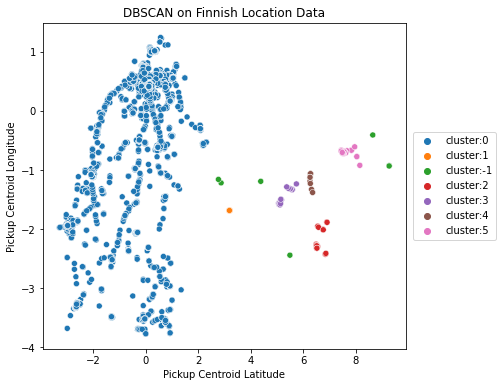

In [45]:
fig = plt.figure(figsize = (6.5,6))
sns.scatterplot(x = scaled_coords[:, 0], y = scaled_coords[:, 1], hue = ["cluster:{}".format(x) for x in db_labels])
plt.legend(bbox_to_anchor=(1.25, 0.5), loc='center right', borderaxespad=0.)

plt.xlabel('Pickup Centroid Latitude')
plt.ylabel('Pickup Centroid Longitude')
plt.title("DBSCAN on Finnish Location Data")

Above is the outcome of DBSCAN when eps = 0.5 and min_samples = 4. The performance of this DBSCAN model is not as slow as that of the trained model on Chicago Taxi Data. Though there is some indication of outliers on the plot, it suggests that there is room for improvement in Cluster 0.

In [47]:
# identify core samples
core_samples = np.zeros_like(db_labels, dtype = bool) # return an array of zeros w/same shape and type as given array
core_samples[dbscan.core_sample_indices_] = True
np.set_printoptions(threshold = np.inf)
print(core_samples)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [48]:
# declare the number of clusters
n_clusters = len(set(db_labels)) - (1 if -1 in labels else 0)
print(n_clusters)

7


In [49]:
db_sil_score = metrics.silhouette_score(scaled_coords, db_labels)
print('Silhouette Coefficient: %0.3f' % db_sil_score)

Silhouette Coefficient: 0.706


Interestingly, the silhouette score of the DBSCAN model is slightly less strong than the K-Means model on this data, which I didn't quite expect, given DBSCAN's ability to take irregular-shaped data as input. 

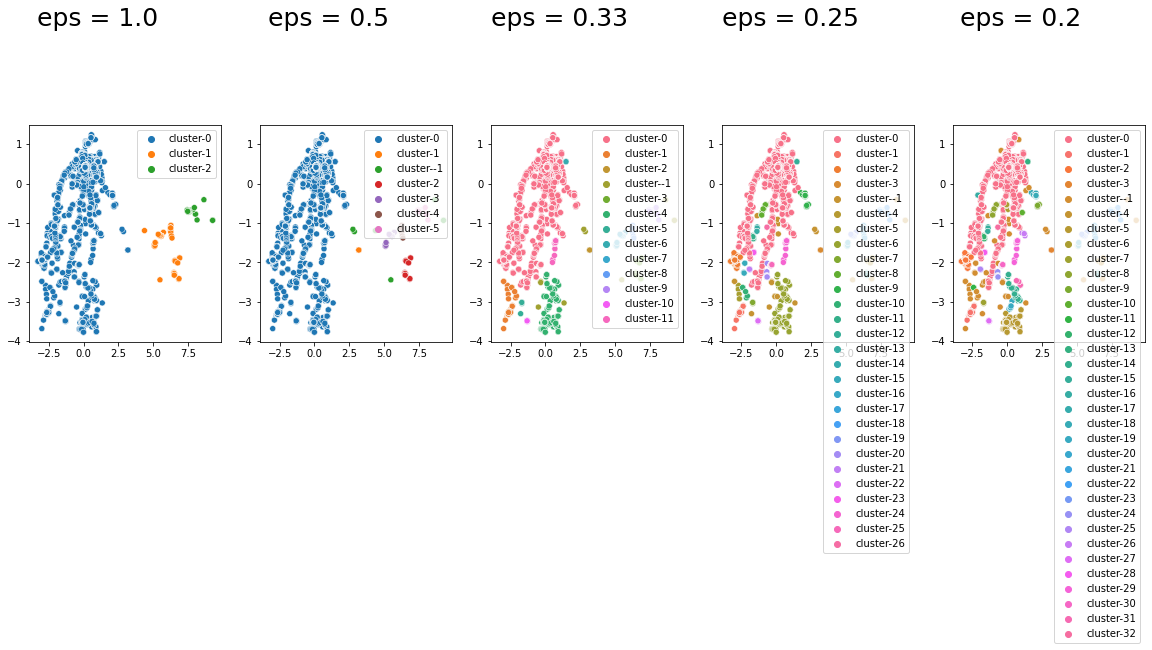

In [52]:
# run DBSCAN x number of times to observe optimal epsilon parameter

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1

for x in range(10, 5, -1):
    eps = 1/(11-x)
    db_scan_trials = DBSCAN(eps = eps, min_samples=4).fit(scaled_coords)
    core_samples_mask = np.zeros_like(db_scan_trials.labels_, dtype=bool)
    core_samples_mask[db_scan_trials.core_sample_indices_] = True
    db_trials_labels = db_scan_trials.labels_
    
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 2)), fontsize=25, ha="center")
    sns.scatterplot(x = scaled_coords[:,0], y = scaled_coords[:,1], hue=["cluster-{}".format(x) for x in db_trials_labels])
    
    i += 1
    
plt.savefig("dbscan_multi_eps2.png", dpi=300)

Towards the left of the subplot displayed above, there seems to be a good chance that a few clusters have been merged together in what the algorithm claimed to be Cluster 0. As the epsilon decreased, more dense clusters begin to emerge. Because the parameter epsilon is seemingly proportional to the expected number of neighbors discovered, we may be able to use K-nearest neighbors as a systematic method to estimate eps.

